# Part 1 - Building up a basic predictive model

## 1.1 Data cleaning and transformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import string
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the file and fixing the headers
def setup_df(fileName, header_row):
    
    df = pd.read_csv(fileName)
    
    df.columns = df.iloc[header_row]
    df = df.drop(index=df.index[:4])

    #Rename incorrectly formatted column names
    df = df.rename({'SALE\nPRICE': 'SALE PRICE', 'APART\nMENT\nNUMBER': 'APARTMENT NUMBER'}, axis=1)

    return df



# Cleaning the dataframe by adjusting the columns, tehir values and their datatypes
def adjust_columns(df):

    #For each numerical column, remove the ','
    for i in numerical_variables:
        df[i].replace(regex=r'\,', value='', inplace=True)

    #remove the '$' for the sale price
    df['SALE PRICE'].replace(regex=r'\$', value='', inplace=True)

    #convert each numerical column to numeric.
    for i in numerical_variables:
        df[i].replace(regex=r'\,', value='', inplace=True)
        df[i] = pd.to_numeric(df[i], errors='coerce') 

    # Convert the 'SALE DATE' to datetime.
    df['SALE DATE'] = df['SALE DATE'].apply(pd.to_datetime, errors='coerce')

    #For each categorical variable, remove the spaces, and then replace the empty string '' by NaN.
    for i in categorical_variables:
        df[i].replace(regex=r'[\s]+', value='', inplace=True)
        df[i] = df[i].replace('', np.nan)

    #Replace the zeros in Prices, Land squares, etc. by NaN
    df[numerical_variables] = df[numerical_variables].replace(0, np.nan)

    #Drop the columns 'BOROUGH', 'EASE-MENT', 'APARTMENT NUMBER'
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT NUMBER'], inplace=True)
    
    return df



# Aggressive cleaning - removing any rows that contain at least 1 missing value
def remove_additional_rows(df):
    
    #Drop duplicates if any
    df.drop_duplicates(inplace=True)

    #Drop rows with NaN values
    df.dropna(inplace=True)
    
    return df



# Treating outliers using standard deviations
def treat_outliers(df, x):
    
    #Identify and remove outliers if any
    num_cols = df.select_dtypes(include=[np.number]).columns
    mean = df[num_cols].mean()
    std = df[num_cols].std()

    outliers = np.abs(df[num_cols] - mean) > x*std
    outliers = outliers.any(axis=1)

    df = df[~outliers]

    return df



# Normalising the dataframe using min-max normalization
def nornalize_df(df):

    #Normalise the data
    df_norm = df.select_dtypes(include=[np.number])
    df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())

    return df_norm





In [3]:
fileName = 'Manhattan12.csv'
header_row = 3

df = setup_df(fileName, header_row)
print('Initial shape:', df.shape)
print('\nColumn names after renaming incorrectly formatted column names:\n', df.columns, "\n")

# List of categorical variables
categorical_variables = ['NEIGHBORHOOD','BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE','BUILDING CLASS AT PRESENT','EASE-MENT','ADDRESS','APARTMENT NUMBER','BUILDING CLASS AT TIME OF SALE','BOROUGH','SALE DATE']

# List of numerical variables
numerical_variables = ['RESIDENTIAL UNITS','COMMERCIAL UNITS','TOTAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','SALE PRICE','BLOCK','LOT','ZIP CODE']

print('\nCategorical Variables:\n', categorical_variables, "\n")
print('\nNumerical variables:\n', numerical_variables, "\n")

print("\n\nInitial columns and their data types:\n",df.dtypes, "\n")
print("\nInitial missing values\n", df.isnull().sum(), "\n")
df = adjust_columns(df)

df

Initial shape: (27395, 21)

Column names after renaming incorrectly formatted column names:
 Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object', name=3) 


Categorical Variables:
 ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT PRESENT', 'EASE-MENT', 'ADDRESS', 'APARTMENT NUMBER', 'BUILDING CLASS AT TIME OF SALE', 'BOROUGH', 'SALE DATE'] 


Numerical variables:
 ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE', 'BLOCK', 'LOT', 'ZIP CODE'] 



Initial c

3,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1306,NaN,345WEST14THSTREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,2214693.0,2013-05-20
5,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1307,NaN,345WEST14THSTREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1654656.0,2013-05-16
6,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1308,NaN,345WEST14THSTREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1069162.0,2013-05-23
7,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1309,NaN,345WEST14THSTREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1374637.0,2013-05-15
8,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1310,NaN,345WEST14THSTREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1649565.0,2013-05-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27394,WASHINGTONHEIGHTSUPPER,31COMMERCIALVACANTLAND,4,2170,400,V1,44FAIRVIEWAVENUE,10040.0,NaN,NaN,NaN,16217.0,NaN,NaN,4,V1,NaN,2013-04-29
27395,WASHINGTONHEIGHTSUPPER,31COMMERCIALVACANTLAND,4,2180,75,V1,BENNETTAVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,495000.0,2013-06-26
27396,WASHINGTONHEIGHTSUPPER,31COMMERCIALVACANTLAND,4,2180,75,V1,BENNETTAVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,NaN,2013-02-04
27397,WASHINGTONHEIGHTSUPPER,31COMMERCIALVACANTLAND,4,2180,76,V1,N/AMAGAWPLACE,10033.0,NaN,NaN,NaN,760.0,NaN,NaN,4,V1,NaN,2013-06-26


In [4]:

print("\nColumns after converting the data types and dropping columns:\n",df.dtypes, "\n")

print("\nSummary of all missing values:\n",df.isnull().sum(), "\n")
print("\nSummary statistics:")

df.describe()


Columns after converting the data types and dropping columns:
 3
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
ZIP CODE                                 float64
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
TAX CLASS AT TIME OF SALE                 object
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object 


Summary of all missing values:
 3
N

3,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,27395.000000,27395.000000,27394.000000,11023.000000,3433.000000,17691.000000,4489.000000,4.326000e+03,20954.000000,1.980200e+04
mean,1109.666728,741.789086,10029.226217,4.390003,2.992426,3.545249,5893.466028,6.061620e+04,1953.080557,2.556609e+06
std,465.994469,819.422424,34.966983,23.260831,12.689861,19.482767,7884.729624,8.111694e+04,37.692641,1.916295e+07
min,7.000000,1.000000,10001.000000,1.000000,1.000000,1.000000,200.000000,2.530000e+02,1000.000000,1.000000e+00
25%,877.000000,37.000000,10016.000000,1.000000,1.000000,1.000000,2104.000000,6.198500e+03,1920.000000,3.676662e+05
50%,1047.000000,1007.000000,10019.000000,1.000000,2.000000,1.000000,5046.000000,2.337150e+04,1955.000000,7.400000e+05
75%,1411.000000,1233.000000,10027.000000,1.000000,2.000000,1.000000,7532.000000,1.128500e+05,1987.000000,1.627399e+06
max,2250.000000,9117.000000,10463.000000,1328.000000,604.000000,1349.000000,213650.000000,1.970736e+06,2013.000000,1.307965e+09


In [5]:
print("\nshape before treating NaN values, dropping duplicates or removing outliers:", df.shape, "\n")
df = remove_additional_rows(df)

# Removing any outliers from numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns
df = treat_outliers(df, 2)
print('\nSummary statistics after treating outliers:')

df.describe()



shape before treating NaN values, dropping duplicates or removing outliers: (27395, 18) 


Summary statistics after treating outliers:


3,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,4.220000e+02
mean,1081.798578,38.969194,10020.734597,13.471564,1.914692,15.355450,3336.831754,14316.194313,1911.400474,6.916273e+06
std,635.039468,32.351932,14.756316,15.065586,1.425030,15.814744,2889.642482,16220.954893,10.464658,6.970253e+06
min,11.000000,1.000000,10001.000000,1.000000,1.000000,1.000000,469.000000,1875.000000,1877.000000,1.000000e+01
25%,485.000000,17.250000,10011.000000,3.000000,1.000000,5.000000,1801.000000,5555.000000,1900.000000,3.012500e+06
50%,959.500000,31.500000,10018.500000,8.000000,1.000000,9.000000,2404.000000,8645.500000,1910.000000,5.092500e+06
75%,1645.000000,49.000000,10029.000000,18.000000,2.000000,20.750000,3554.000000,15151.500000,1920.000000,8.275000e+06
max,2230.000000,163.000000,10075.000000,105.000000,8.000000,112.000000,15987.000000,111457.000000,1950.000000,5.000000e+07


In [6]:
print("\nmissing values after removing outliers:\n",df.isnull().sum(), "\n")
print("\nshape of the resulting dataframe:", df.shape, "\n")


df['log of SALE PRICE'] = np.log(df['SALE PRICE'])

# normalising only numeric columns
numeric_df = df.select_dtypes(include=np.number)
df_norm = nornalize_df(numeric_df)

print("\nNormalised dataset:")

df_norm.describe()


missing values after removing outliers:
 3
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64 


shape of the resulting dataframe: (422, 18) 


Normalised dataset:


3,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,log of SALE PRICE
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,0.482559,0.234378,0.266684,0.119919,0.130670,0.129328,0.184807,0.113533,0.471239,0.138325,0.829964
std,0.286183,0.199703,0.199410,0.144861,0.203576,0.142475,0.186212,0.148026,0.143351,0.139405,0.133617
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.213610,0.100309,0.135135,0.019231,0.000000,0.036036,0.085836,0.033582,0.315068,0.060250,0.817874
50%,0.427445,0.188272,0.236486,0.067308,0.000000,0.072072,0.124694,0.061785,0.452055,0.101850,0.851912
75%,0.736368,0.296296,0.378378,0.163462,0.142857,0.177928,0.198801,0.121156,0.589041,0.165500,0.883384
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print('dataframe after considering the log of the prices and normalising the data:')
df_norm

dataframe after considering the log of the prices and normalising the data:


3,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,log of SALE PRICE
30,0.173952,0.197531,0.108108,0.230769,0.142857,0.234234,0.200090,0.149085,0.657534,0.263714,0.913589
34,0.174403,0.320988,0.108108,0.336538,0.285714,0.342342,0.256670,0.144084,0.315068,0.076212,0.833112
35,0.175304,0.339506,0.108108,0.086538,0.000000,0.081081,0.124694,0.046540,0.315068,0.146666,0.875553
36,0.175304,0.345679,0.108108,0.076923,0.000000,0.072072,0.124694,0.045628,0.315068,0.146666,0.875553
37,0.175304,0.351852,0.108108,0.076923,0.000000,0.081081,0.124694,0.047772,0.315068,0.146666,0.875553
...,...,...,...,...,...,...,...,...,...,...,...
27056,0.975214,0.271605,0.527027,0.644231,0.714286,0.657658,0.987949,0.515824,0.589041,0.226000,0.903583
27061,0.977467,0.074074,0.432432,0.528846,0.000000,0.504505,0.881621,0.387107,0.657534,0.172400,0.886033
27063,0.977467,0.734568,0.432432,0.653846,0.571429,0.657658,0.768849,0.475671,0.986301,0.228000,0.904155
27064,0.967553,0.092593,0.527027,0.644231,0.285714,0.630631,0.886841,0.587368,0.465753,0.156200,0.879635


## 1.2 Data Exploration

#### Prices across neighborhood

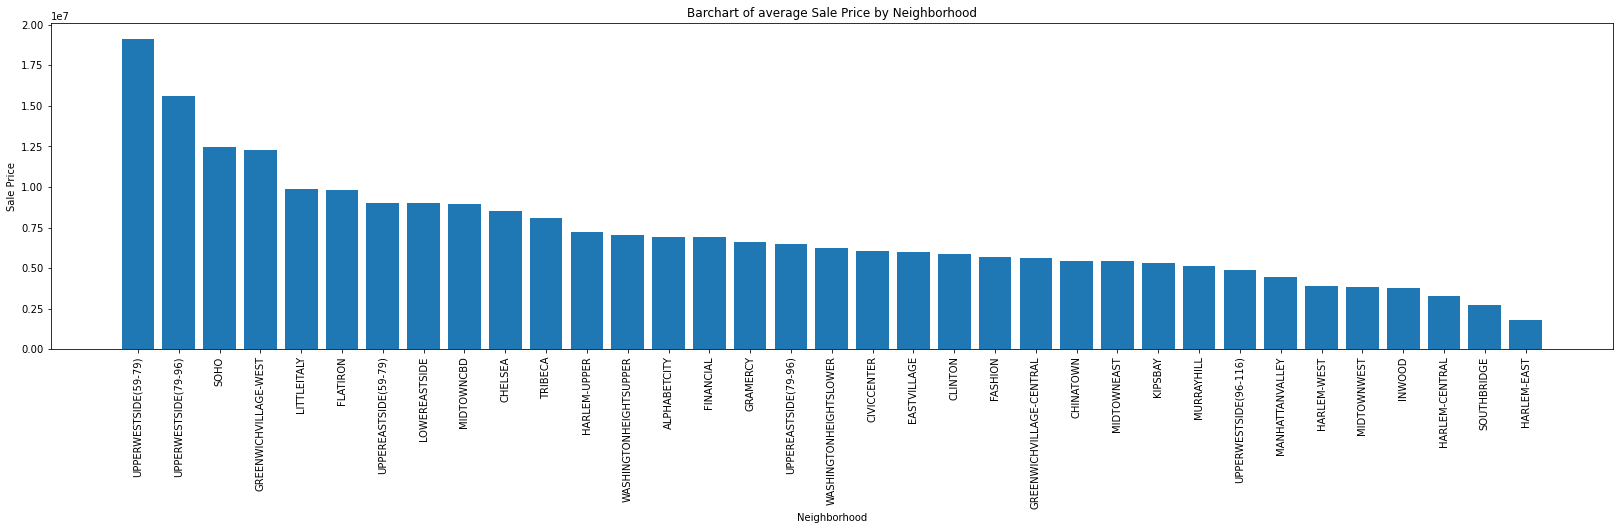

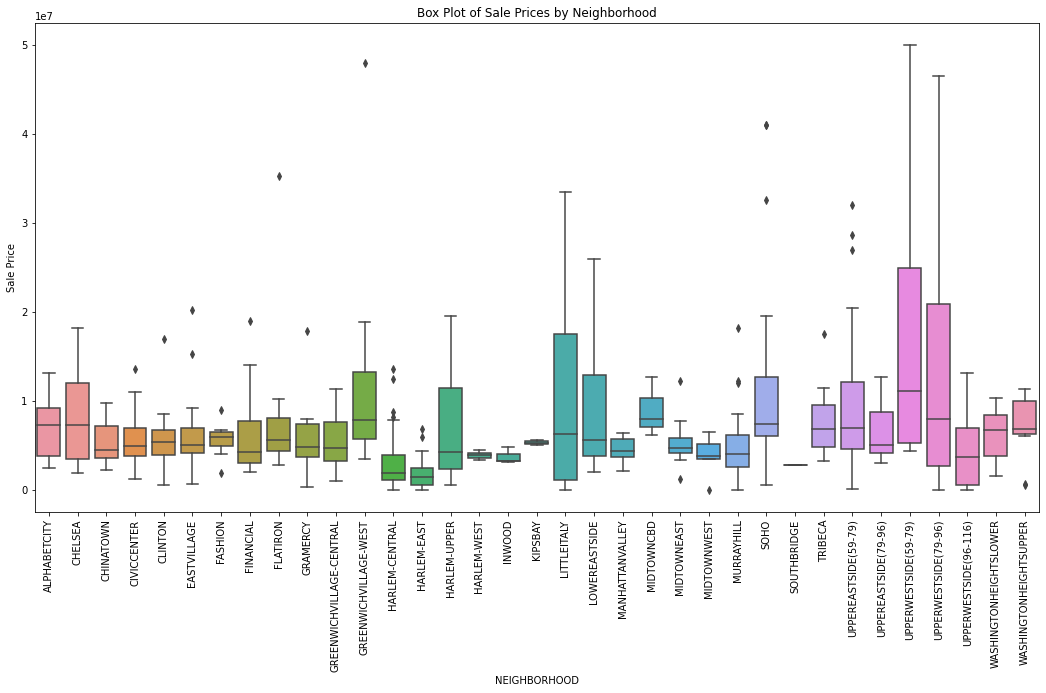

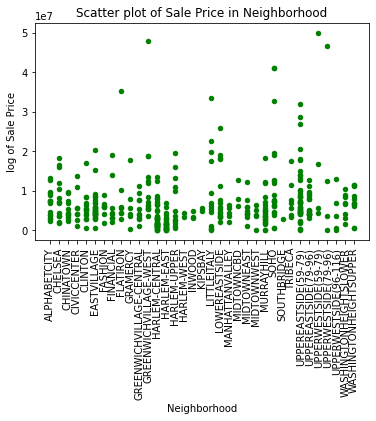

In [8]:
# Barchart of average 'SALE PRICE' for each 'NEIGHBORHOOD'
grouped_data = df.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
sorted_data = grouped_data.sort_values(ascending=False)

plt.figure(figsize=(28, 6))
plt.bar(sorted_data.index, sorted_data.values)
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price')
plt.title('Barchart of average Sale Price by Neighborhood')
plt.xticks(rotation=90)

plt.show()


# Box Plot of 'SALE PRICE' by 'NEIGHBORHOOD'
plt.figure(figsize=(18, 9))
sns.boxplot(x='NEIGHBORHOOD', y='SALE PRICE', data=df)
plt.xlabel('NEIGHBORHOOD')
plt.ylabel('Sale Price')
plt.title('Box Plot of Sale Prices by Neighborhood')
plt.xticks(rotation=90)

plt.show()


# Scatter plot of 'SALE PRICE' in 'NEIGHBORHOOD'
ax = df.plot.scatter(x='NEIGHBORHOOD', y='SALE PRICE', title='Scatter plot of Sale Price in Neighborhood', color='g')
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('log of Sale Price')

plt.show()

#### Prices over time

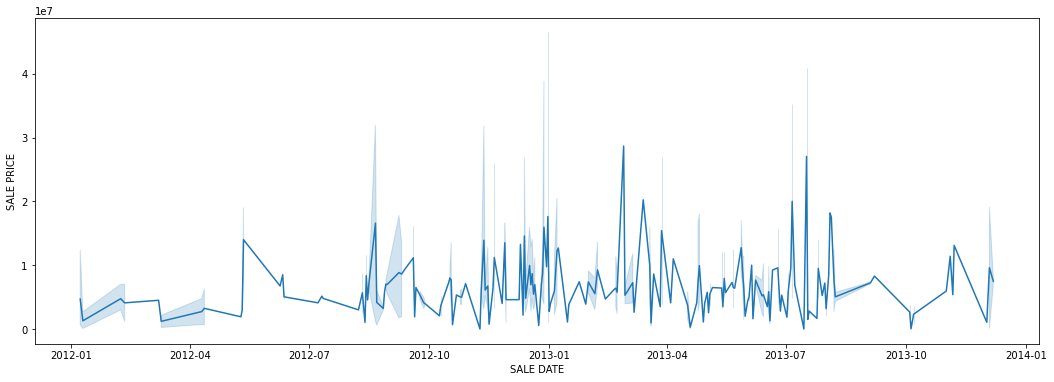

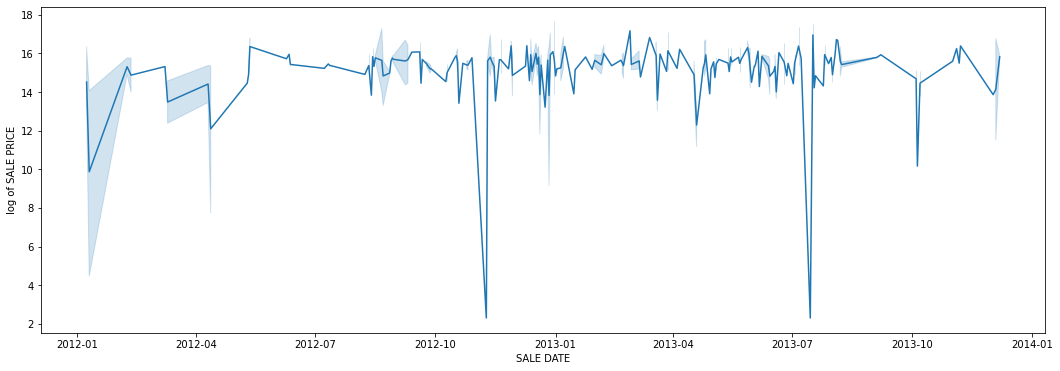

In [9]:
# SALE PRICE over time
plt.figure(figsize=(18, 6))
sns.lineplot(data=df, x='SALE DATE', y='SALE PRICE')
plt.show()

# log of SALE PRICE over time
plt.figure(figsize=(18, 6))
sns.lineplot(data=df, x='SALE DATE', y='log of SALE PRICE')
plt.show()

#### Scatter matrix plot

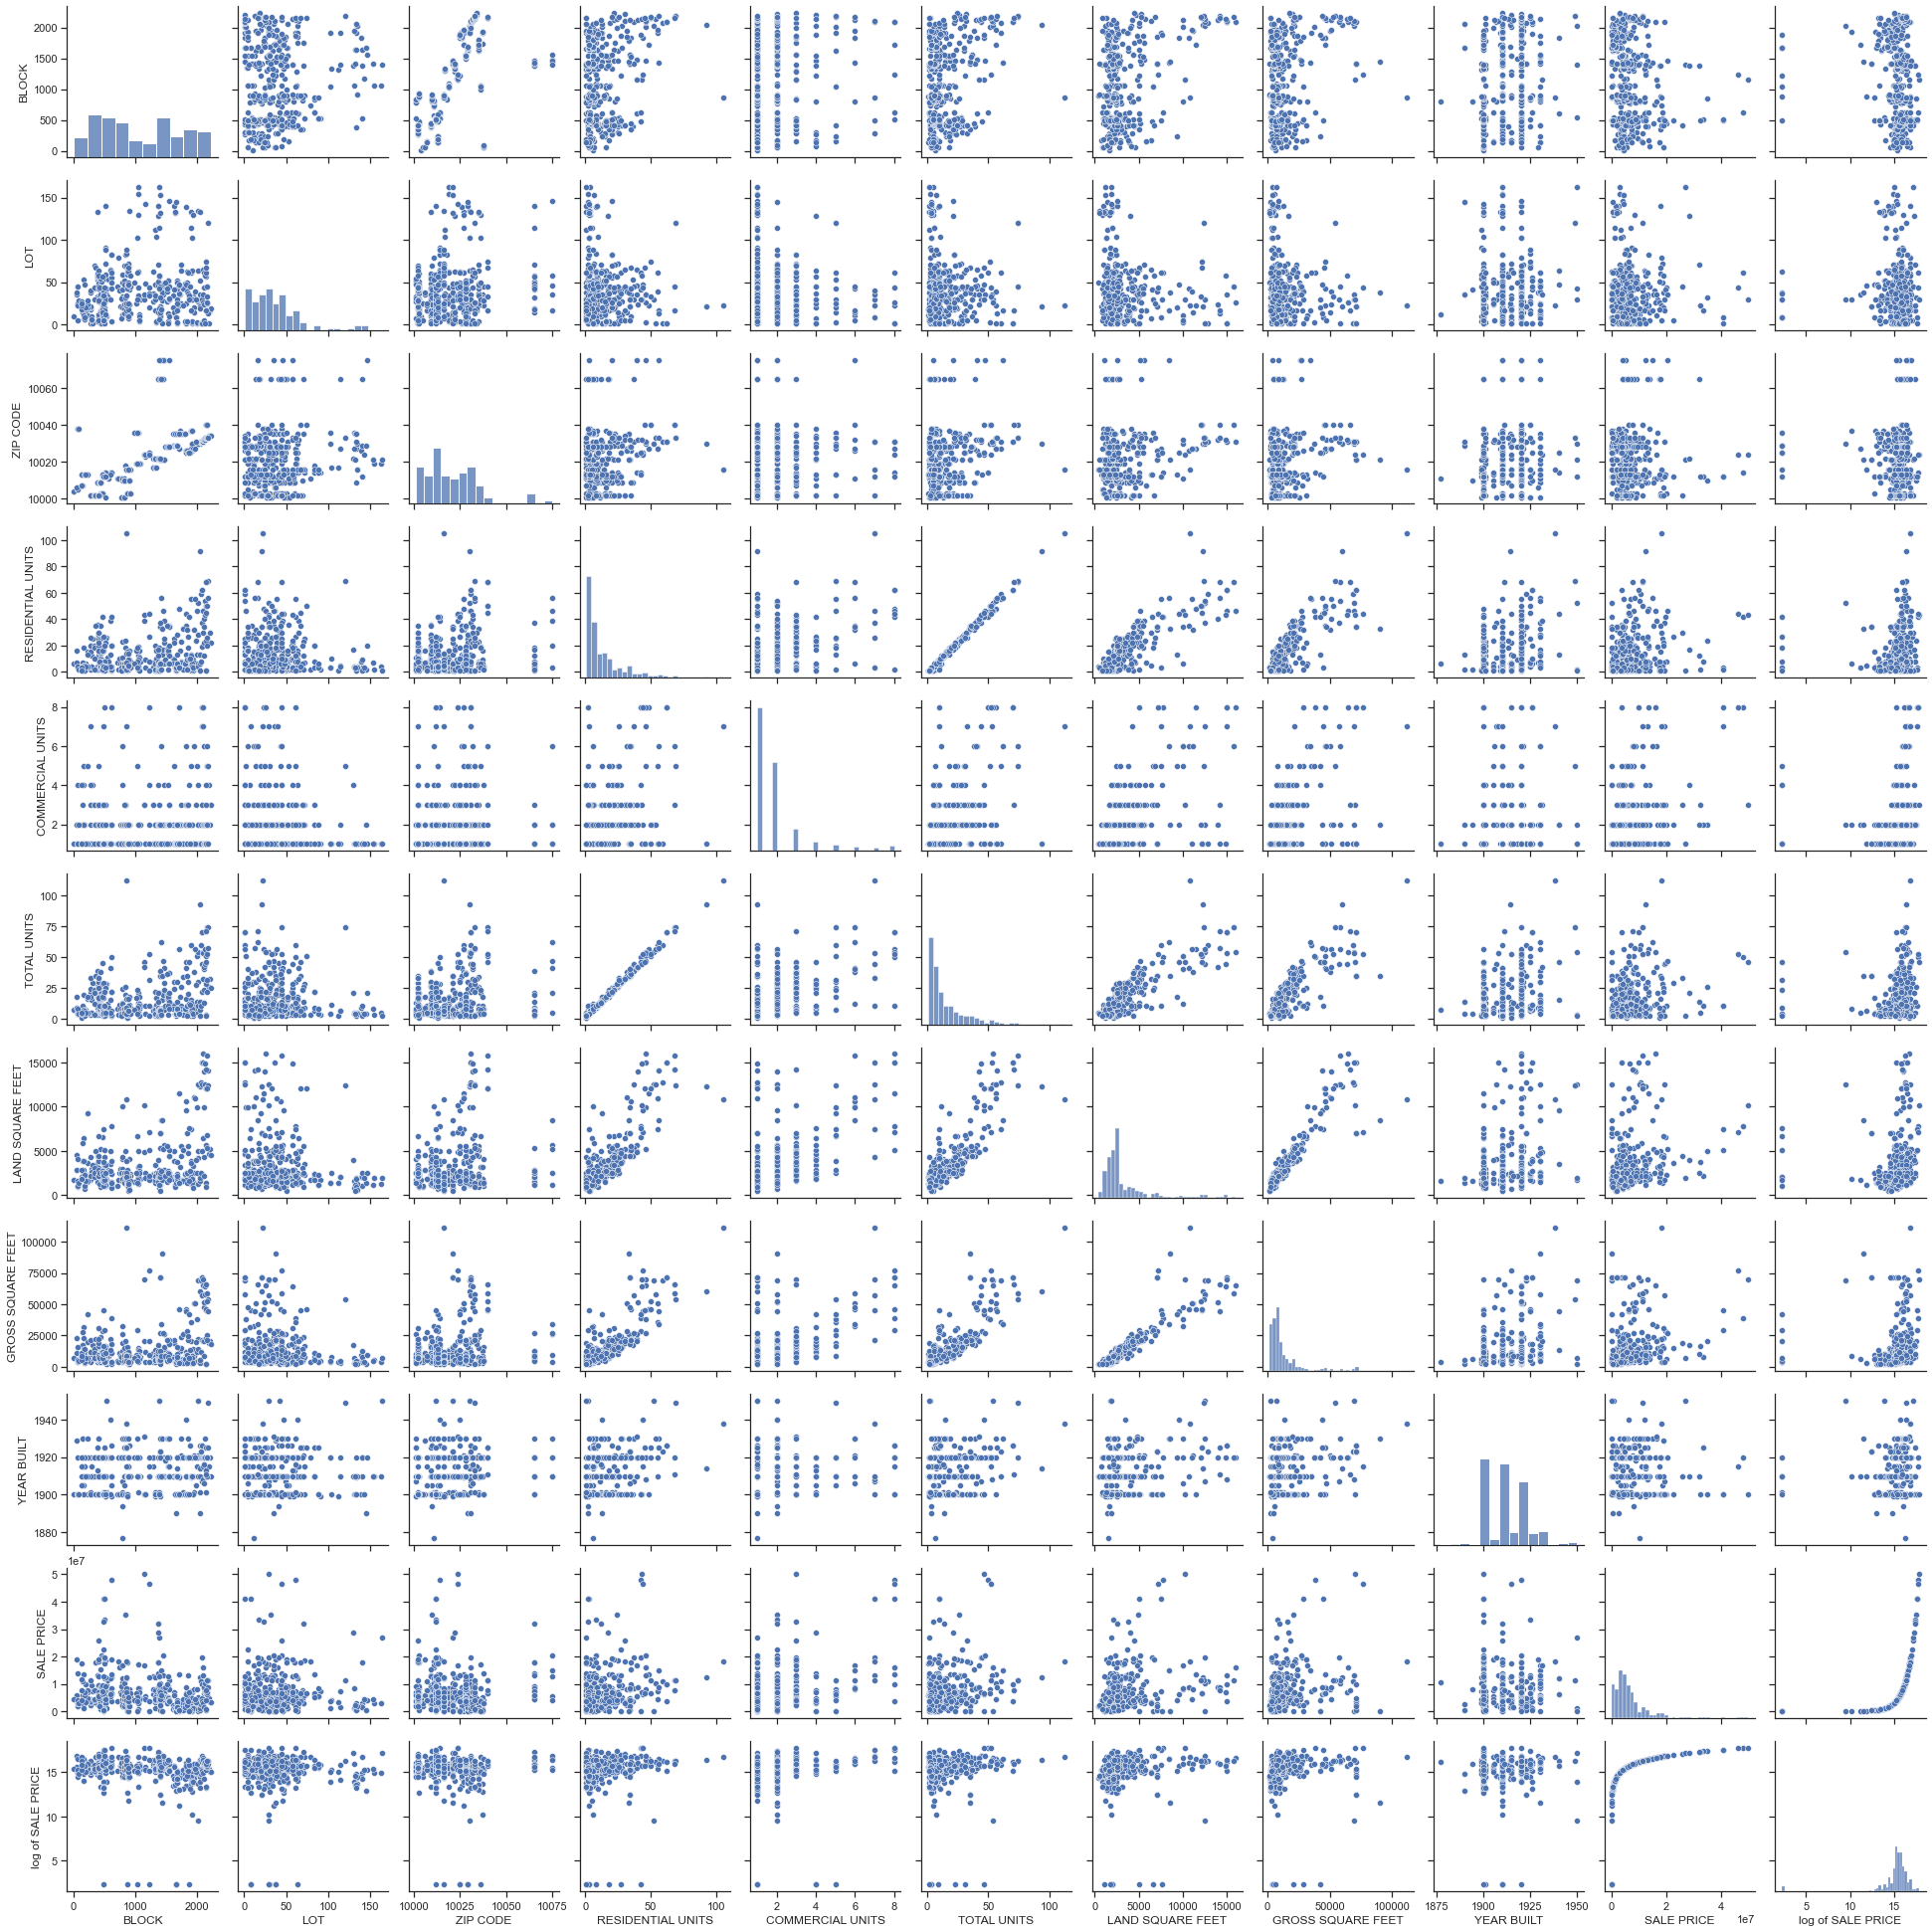

'Done'

In [10]:
#Scatter matrix plot

plot_cols = [
 'BLOCK',
 'LOT',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'SALE PRICE',
 'log of SALE PRICE']
       
def matrix_plot(plot_cols, df):
    sns.set(style="ticks")
    sns.pairplot(df[plot_cols])
    plt.show()
    return('Done')
matrix_plot(plot_cols, df)

#### Correlation matrix

In [11]:
df.corr()

3,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,log of SALE PRICE
3,,,,,,,,,,,
BLOCK,1.000000,0.129221,0.664090,0.323573,0.107909,0.319062,0.364368,0.292250,0.209025,-0.165977,-0.168283
LOT,0.129221,1.000000,0.161533,-0.099958,-0.122165,-0.106562,-0.144061,-0.144549,0.053632,-0.027804,0.001488
ZIP CODE,0.664090,0.161533,1.000000,0.200503,0.055061,0.196736,0.197334,0.152078,0.172139,-0.015092,-0.069038
RESIDENTIAL UNITS,0.323573,-0.099958,0.200503,1.000000,0.487141,0.996765,0.838128,0.831011,0.303214,0.256875,0.113736
COMMERCIAL UNITS,0.107909,-0.122165,0.055061,0.487141,1.000000,0.554793,0.579277,0.539862,0.106786,0.417836,0.130711
TOTAL UNITS,0.319062,-0.106562,0.196736,0.996765,0.554793,1.000000,0.851207,0.840885,0.298734,0.281674,0.119372
LAND SQUARE FEET,0.364368,-0.144061,0.197334,0.838128,0.579277,0.851207,1.000000,0.902764,0.311278,0.283563,0.100646
GROSS SQUARE FEET,0.292250,-0.144549,0.152078,0.831011,0.539862,0.840885,0.902764,1.000000,0.324232,0.305608,0.073873
YEAR BUILT,0.209025,0.053632,0.172139,0.303214,0.106786,0.298734,0.311278,0.324232,1.000000,0.047291,0.054234


#### Additional plots

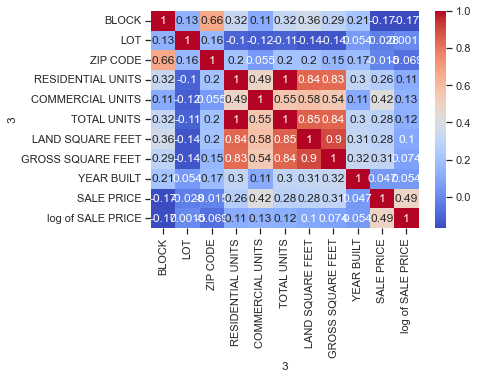

In [12]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

<Figure size 864x360 with 0 Axes>

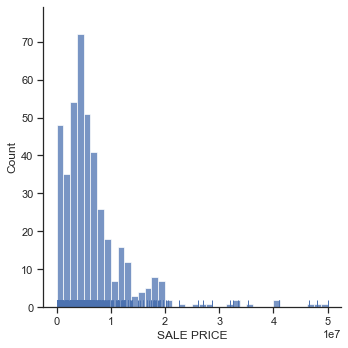

In [13]:
plt.figure(figsize=(12,5))
sns.displot(df['SALE PRICE'], bins=40, rug=True)
plt.show()

## 1.3. Model building

#### Predictors

In [14]:
#Select the predictors that would have impact in predicting house prices.

from sklearn import svm, feature_selection, linear_model
df = df_norm.select_dtypes(include=[np.number]).copy()
plot_cols = df.columns.values.tolist()
plot_cols.remove('SALE PRICE')
plot_cols.remove('log of SALE PRICE')
XO = df[plot_cols]
YO = df['SALE PRICE']
estimator = svm.SVR(kernel="linear")
selector = feature_selection.RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(XO, YO)

select_features = np.array(plot_cols)[selector.ranking_ == 1].tolist()
print(select_features)

['BLOCK', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']


#### Linear model

In [15]:
from sklearn.model_selection import train_test_split

X = df_norm[select_features]
Y = df_norm['SALE PRICE']
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

lm = linear_model.LinearRegression()
lm.fit(trainX, trainY)
print("R squared for the training data is {:4.3f}".format(lm.score(trainX, trainY)))
print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))

R squared for the training data is 0.281
Score against test data: 0.149


#### Histogram of the residuals

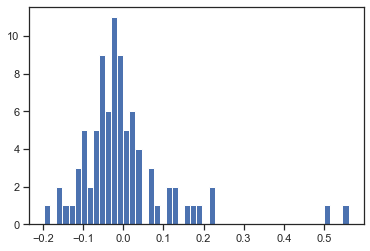

In [16]:
y_pred = lm.predict(testX)

residuals = testY - y_pred

plt.hist(residuals, bins=50)
plt.show()

#### Cross-validation

In [17]:
X = df[select_features]
y = df['SALE PRICE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the numerical variables using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a linear regression model
lr = LinearRegression()
lr.fit(trainX, trainY)

# Calculate cross-validation scores
scores = cross_val_score(lr, X_train, y_train, cv=5)

# Print the scores and the average score
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [-0.20847091  0.13157084  0.38554797  0.41202426 -0.21313583]
Average cross-validation score: 0.10150726642210366


# Part 2 - Improved model

## 2.1 Improved predictive model

In [18]:
# Cleaning the data frame
def clean_df(df):
    
    #remove the '$' for the sale price
    df['SALE PRICE'].replace(regex=r'\$', value='', inplace=True)

    # For each numerical column, remove the ',' and convert to numeric.
    for i in numeric_variables:
        df[i].replace(regex=r'\,', value='', inplace=True)
        df[i] = pd.to_numeric(df[i], errors='coerce')
    
    # If 'GROSS SQUARE FEET' is equal to 0, give it the value of the corresponding 'LAND SQUARE FEET'
    df.loc[df['GROSS SQUARE FEET'] == 0, 'GROSS SQUARE FEET'] = df['LAND SQUARE FEET']

    # Filter out extreme 'SALE PRICE' values
    df = df[(df['SALE PRICE']>20000) & (df['SALE PRICE']<500000000)]

    # Adding 'log of SALE PRICE' to data frame
    df['log of SALE PRICE'] = np.log(df['SALE PRICE'])

    # Dropping 'SALE PRICE' column and removing it from numeric_variables
    df.drop(columns=['SALE PRICE'], inplace=True)
    numeric_variables.remove('SALE PRICE')

    #Replace the zeros in Prices, Land squares, etc. by NaN
    df[num_variables] = df[num_variables].replace(0, np.nan)
    
    # Fill in any missing values in 'YEAR BUILT' with the median
    df['YEAR BUILT'] = df['YEAR BUILT'].fillna(df['YEAR BUILT'].median())
    
    return df



# Random forest model for treating missing values
def Random_forest_model(df, features_with_missing_values):

    # Split the data
    train_data = df[df[features_with_missing_values].notnull().all(axis=1)]
    test_data = df[df[features_with_missing_values].isnull().any(axis=1)]

    # Train a Random Forest model on the data set that has non-missing values for the feature(s) you want to impute
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_data.drop(features_with_missing_values, axis=1), train_data[features_with_missing_values])

    # Predict the missing values
    predicted_values = rf.predict(test_data.drop(features_with_missing_values, axis=1))

    # Impute the missing values
    df.loc[df[features_with_missing_values].isnull().any(axis=1), features_with_missing_values] = predicted_values

    return df




# Regression model to evaluate the results
def regression_model(lr, select_features):
    X = df[select_features]
    y = df['log of SALE PRICE']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the numerical variables using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Calculate cross-validation scores
    scores = cross_val_score(lr, X_train, y_train, cv=5)

    print("Cross-validation scores:", scores)
    print("Average cross-validation score:", scores.mean())

    # Fit the Linear regression model on the training data
    lr.fit(X_train, y_train)

    # Make predictions on training and the test data
    y_train_pred = lr.predict(X_train)
    y_pred = lr.predict(X_test)

    # Calculating the mean squared error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2 = r2_score(y_test, y_pred)
    
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

    print("Mean squared error:", mse)
    print("R squared for the training data:", r2_train)
    print("R-squared for test data:", r2)
    

In [19]:
fileName = 'Manhattan12.csv'
header_row = 3

df = setup_df(fileName, header_row)
print('Initial data frame:\n\n')
print(df.info(), '\n\n')

# Remove duplicates
df.drop_duplicates(inplace=True)

# Defining numerical variables
numeric_variables = ['TOTAL UNITS','SALE PRICE','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','RESIDENTIAL UNITS','COMMERCIAL UNITS',]

# Numerical variables where 0 will be considered a missing value
num_variables = ['LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT']

# Defining categorical variables
categorical_variables = ['NEIGHBORHOOD','BUILDING CLASS CATEGORY','BUILDING CLASS AT TIME OF SALE',]

# Dropping unneccessary columns
df.drop(columns=['TAX CLASS AT TIME OF SALE','BOROUGH', 'BLOCK', 'ZIP CODE', 'LOT','EASE-MENT', 'APARTMENT NUMBER', 'ADDRESS', 'SALE DATE', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT','NEIGHBORHOOD', 'BUILDING CLASS CATEGORY','BUILDING CLASS AT TIME OF SALE'], inplace=True)

# Numerical columns to normalize
num_cols = ['TOTAL UNITS','RESIDENTIAL UNITS','COMMERCIAL UNITS','log of SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', ]

# Cleaning and adjusting the data types
df = clean_df(df)

print(df.info())
df.describe()

Initial data frame:


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27395 entries, 4 to 27398
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         27395 non-null  object
 1   NEIGHBORHOOD                    27395 non-null  object
 2   BUILDING CLASS CATEGORY         27395 non-null  object
 3   TAX CLASS AT PRESENT            27395 non-null  object
 4   BLOCK                           27395 non-null  object
 5   LOT                             27395 non-null  object
 6   EASE-MENT                       27395 non-null  object
 7   BUILDING CLASS AT PRESENT       27395 non-null  object
 8   ADDRESS                         27395 non-null  object
 9   APARTMENT NUMBER                27395 non-null  object
 10  ZIP CODE                        27395 non-null  object
 11  RESIDENTIAL UNITS               27395 non-null  object
 12  COMMERCIAL UNITS        

3,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,log of SALE PRICE
count,17893.000000,17893.000000,17893.000000,2246.000000,2251.000000,17893.000000,17893.000000
mean,1.524004,0.259990,1.820265,5873.315672,52539.714349,1950.485162,13.697998
std,10.009494,2.295961,10.409382,7713.430858,68950.006799,32.651558,1.260668
min,0.000000,0.000000,0.000000,469.000000,503.000000,1800.000000,9.907231
25%,0.000000,0.000000,0.000000,2018.000000,5400.000000,1925.000000,13.060488
50%,0.000000,0.000000,1.000000,4518.500000,15150.000000,1951.000000,13.635187
75%,1.000000,0.000000,1.000000,7532.000000,112850.000000,1966.000000,14.400516
max,538.000000,150.000000,550.000000,150322.000000,865759.000000,2013.000000,19.968243





Box plots before removing outliers



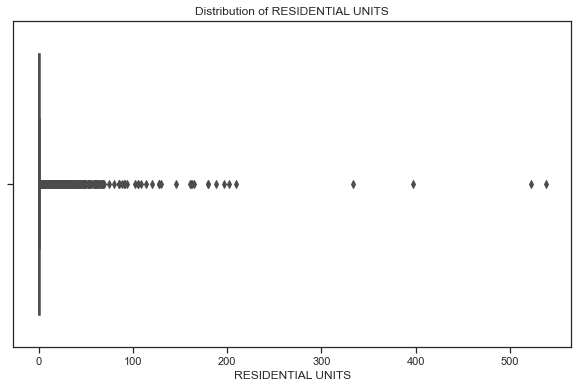

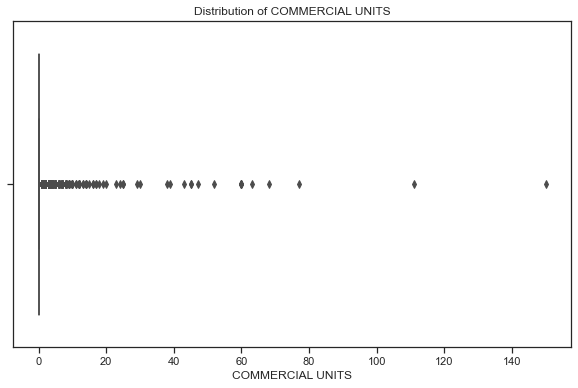

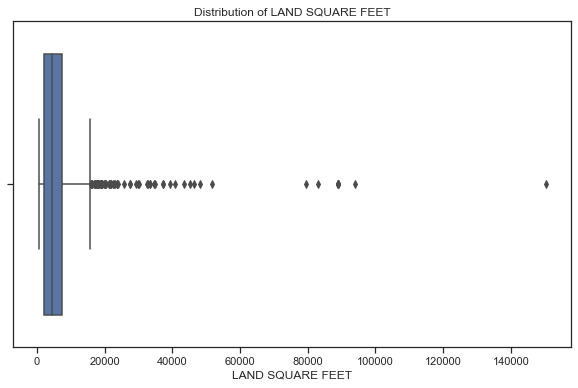

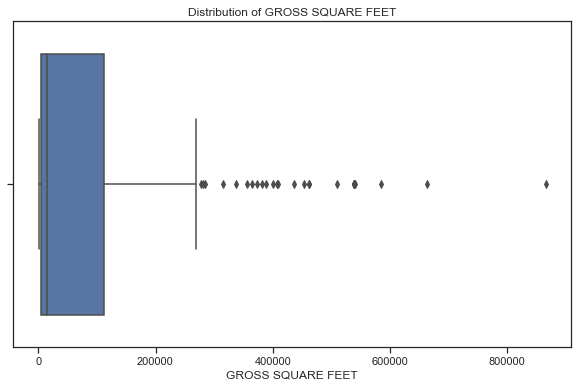

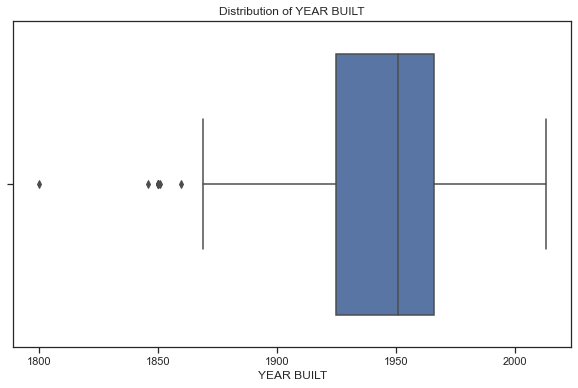





Box plots after removing outliers:



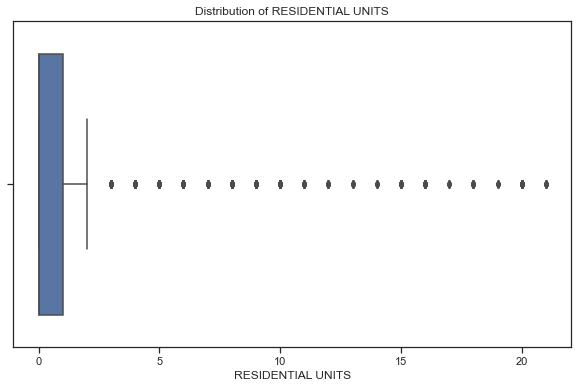

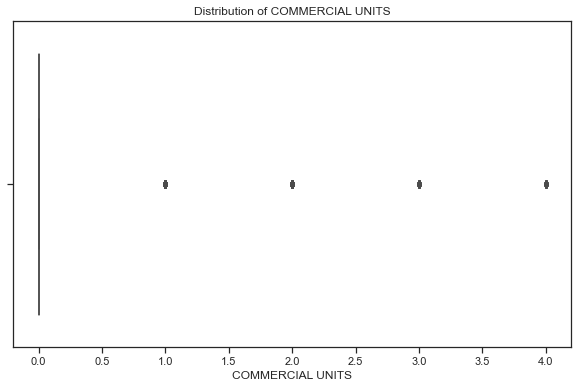

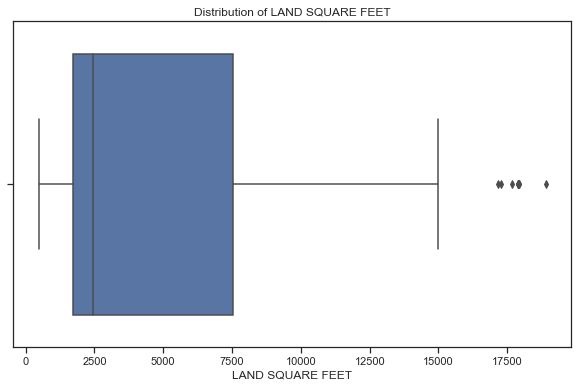

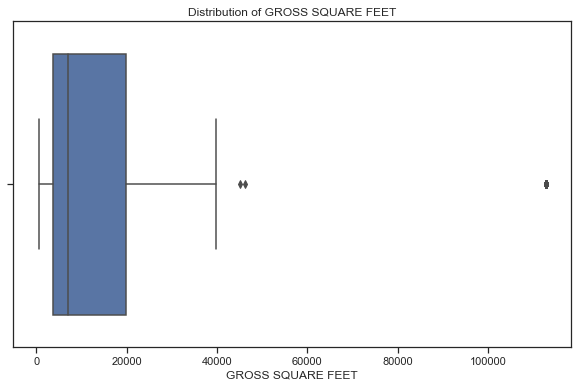

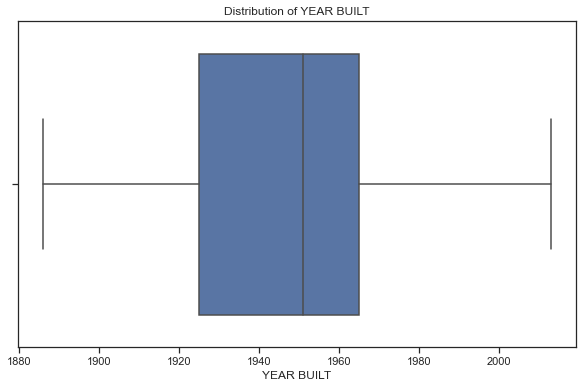

In [20]:
boxplot_cols = ['RESIDENTIAL UNITS','COMMERCIAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT']

# box plots  removing outliers 
print('\n\n\nBox plots before removing outliers\n')

for col in boxplot_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()
    

df = treat_outliers(df, 2)

# box plots after removing outliers
print('\n\n\n\nBox plots after removing outliers:\n')
for col in boxplot_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()
     

In [21]:
# Identify the features with missing values
features_with_missing_values = ['LAND SQUARE FEET', 'GROSS SQUARE FEET']

# Normalizing the data
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Treating missing values
df = Random_forest_model(df, features_with_missing_values)
print(df.isnull().sum())



3
RESIDENTIAL UNITS    0
COMMERCIAL UNITS     0
TOTAL UNITS          0
LAND SQUARE FEET     0
GROSS SQUARE FEET    0
YEAR BUILT           0
log of SALE PRICE    0
dtype: int64


In [22]:
print(df.shape)

(16349, 7)


In [23]:
#Select the predictors that would have impact in predicting house prices.

plot_cols = df.columns.values.tolist()
# plot_cols.remove('SALE PRICE')
plot_cols.remove('log of SALE PRICE')
XO = df[plot_cols]
YO = df['log of SALE PRICE']
estimator = svm.SVR(kernel="linear")
selector = feature_selection.RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(XO, YO)

select_features = np.array(plot_cols)[selector.ranking_ == 1].tolist()
print(select_features)

['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']


Cross-validation scores: [0.1651606  0.13565222 0.12948502 0.14287406 0.15710712]
Average cross-validation score: 0.14605580149113


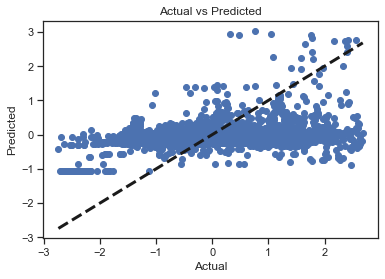

Mean squared error: 0.8814289931956645
R squared for the training data: 0.14782239292032817
R-squared for test data: 0.13723091726073344


In [24]:
# Testing the linear regression predictive model
lr = linear_model.LinearRegression()
regression_model(lr, select_features)

Based on the current results, we can clearly see that the linear regression model did not cause such a significant improvement.
Therefore, we will now use random forest since it is known for being effective in regression and classification.

Cross-validation scores: [0.8709739  0.87980871 0.87918047 0.86741825 0.86072169]
Average cross-validation score: 0.8716206055987051


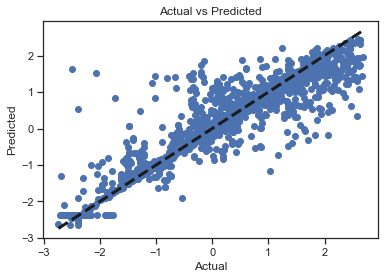

Mean squared error: 0.12557331426062193
R squared for the training data: 0.9819102237389851
R-squared for test data: 0.877085081160796
Out-of-bag R-2 score estimate: 0.882


In [25]:
# Testing the random forest predictive model

lr = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
regression_model(lr, select_features)
print(f'Out-of-bag R-2 score estimate: {lr.oob_score_:>5.3}')

The results that we are getting now seem promising since they are much better. To see if our model can be further enhanced, we will build a cluster-based model and compare the results.

## 2.2 Clustering the cleansed dataset

2 61837.71209322142
3 47124.12687683801
4 37156.21929251951
5 29037.804044648008
6 25123.976957311712
7 22050.30412393745
8 19652.925522641126
9 17794.351573492575
10 16554.431155346534
11 15417.742665957496
12 14290.023099078584
13 13382.976686917691
14 12454.487790966483


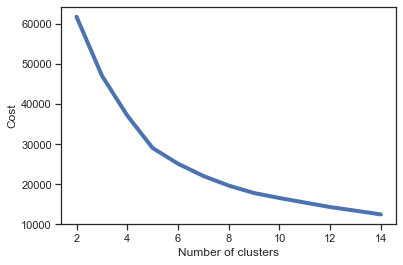

DONE


In [26]:
# Choosing the number of clusters to use
def elbow(data):
    sse = {}
    for k in range(2, 15):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
    
elbow(df)

From the elbow method, we can deduce that an appropriate number of cluster would be 5.

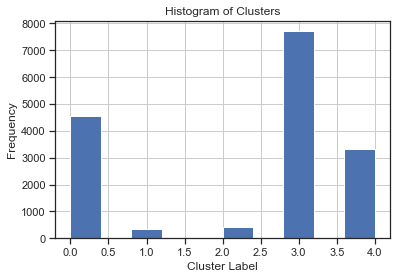

In [27]:
# Load, preprocess and cluster the dataset

kmeans = KMeans(n_clusters=5)
kmeans.fit(df)
cluster_labels = kmeans.predict(df)
df['cluster'] = cluster_labels


# Plot histogram of cluster labels
plt.hist(df['cluster'])
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Histogram of Clusters')
plt.grid()
plt.show()




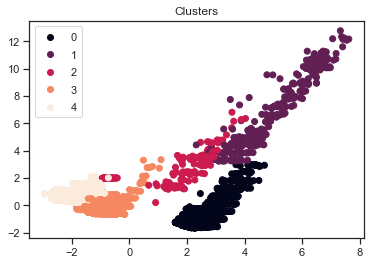

In [28]:
labels = kmeans.labels_
pca_data = PCA(n_components=2).fit(df)
pca_2d = pca_data.transform(df)
scatter = plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
plt.legend(*scatter.legend_elements())
plt.title('Clusters')
plt.show()

#### Comparing the obtained clusters with the distribution found in the data

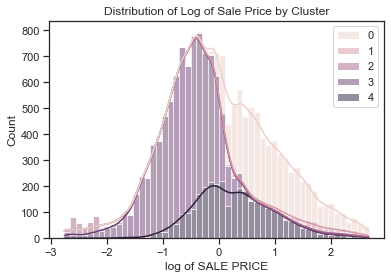

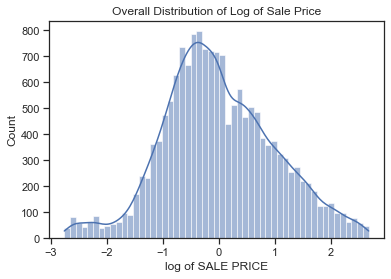

In [29]:


# Distribution of log of SALE PRICE by cluster
sns.histplot(data=df, x='log of SALE PRICE', hue=labels, kde=True, alpha=0.5, multiple='stack')
plt.title('Distribution of Log of Sale Price by Cluster')
plt.show()

# Overall distribution of log of SALE PRICE
sns.histplot(data=df, x='log of SALE PRICE', kde=True, alpha=0.5)
plt.title('Overall Distribution of Log of Sale Price')
plt.show()

As compared to the overall distribution in the second plot, the clusters in the first plot appear to have different forms and sizes of distribution. This shows that using certain underlying patterns or features in the data, the clustering algorithm was successful in grouping comparable sale prices together.

As we can see, some of the clusters in the first plot have distributions that are comparable to the overall distribution in the second plot, while other clusters have entirely different distributions. This implies that while some clusters might reflect subgroups or population segments with comparable sale prices, others might represent outliers or different groupings with unique characteristics.

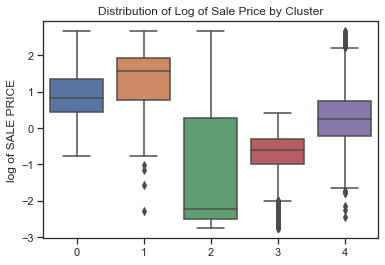

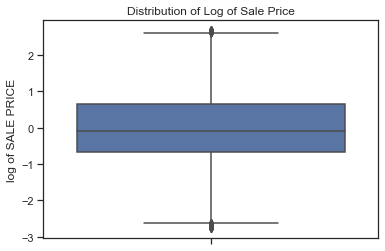

In [30]:

sns.boxplot(x=labels, y='log of SALE PRICE', data=df)
plt.title('Distribution of Log of Sale Price by Cluster')
plt.show()

sns.boxplot(y='log of SALE PRICE', data=df)
plt.title('Distribution of Log of Sale Price')
plt.show()



## 2.3 Building up local regressors based on clustering

Cluster 0 has 4544 data points.
Cluster 1 has 340 data points.
Cluster 2 has 423 data points.
Cluster 3 has 7710 data points.
Cluster 4 has 3332 data points.


Cluster 0:
 Training R-squared: 0.9645361014754261
 Testing R-squared: 0.9593710123531405
 MSE: 0.016453265956501505



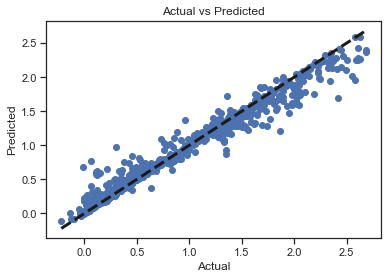

Cluster 1:
 Training R-squared: 0.8900027870311845
 Testing R-squared: 0.8863738040444679
 MSE: 0.07375092505855295



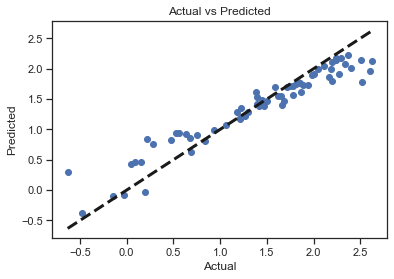

Cluster 2:
 Training R-squared: 0.972610212165724
 Testing R-squared: 0.9816544210379259
 MSE: 0.07080492890665047



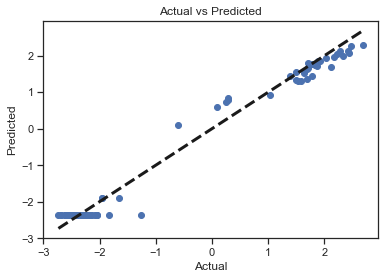

Cluster 3:
 Training R-squared: 0.9872184984578977
 Testing R-squared: 0.9809533501009879
 MSE: 0.005353800829093068



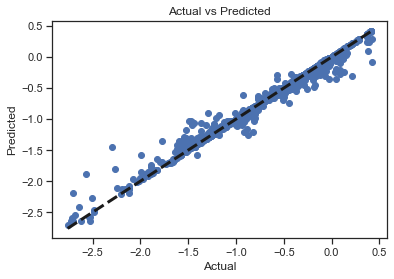

Cluster 4:
 Training R-squared: 0.9883298755513835
 Testing R-squared: 0.9852201410051007
 MSE: 0.007764431135965747



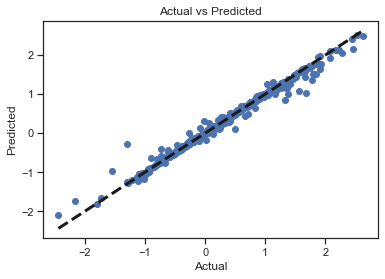


Average R-squared: 0.9587145457083246
Average MSE: 0.034825470377352744


In [31]:
# Creating a regression model for each cluster    
models = {}
for cluster in np.unique(cluster_labels):
    X = df[df['cluster']==cluster].drop(['log of SALE PRICE', 'cluster'], axis=1)
    y = df[df['cluster']==cluster]['log of SALE PRICE']
    model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True).fit(X, y) 
    models[cluster] = model


# Number of data points used for each cluster
for cluster in np.unique(cluster_labels):
    num_data_points = df[df['cluster']==cluster].shape[0]
    print(f"Cluster {cluster} has {num_data_points} data points.")

print('\n')
mean_r_squared = 0
mean_mse = 0
# Evaluating the model
for cluster in models:
    X = df[df['cluster']==cluster].drop(['log of SALE PRICE', 'cluster'], axis=1)
    y = df[df['cluster']==cluster]['log of SALE PRICE']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = models[cluster].predict(X_test)
    
    r2_train = models[cluster].score(X_train, y_train)
    
    y_test_pred = models[cluster].predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    mean_r_squared += r2_test
    
    mse = mean_squared_error(y_test, y_pred)
    mean_mse += mse
    
    print(f"Cluster {cluster}:\n Training R-squared: {r2_train}\n Testing R-squared: {r2_test}\n MSE: {mse}\n")
    
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

print(f'\nAverage R-squared: {mean_r_squared/5}\nAverage MSE: {mean_mse/5}')

Generally, compared to the regression model obtained in Part 2.1, each individual cluster the clusters-based regression model performs better, has a lower mean squared error and the R-squared for the testing and the training data are closer to one another. This is especially true for bigger clusters.

In the clusters-based regression model, the average R-squared of the clusters is higher and the average MSE is lower compared to those in the regression model obtained in Part 2.1; hence, overall, the clusters-based regression model performs better than the regression model.